In [23]:
# interpolate averaging kernel: from OCO2 20 levels to GEOS-Chem 47 levels

In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [25]:
# Name of input Netcdf file
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
model_file_name = '2d_ts_Mar.nc' # model output: March emitting case
oco2_file_name = '2d_OCO2_extract.nc'
output_directory = input_directory
# Name of output netCDF file
output_file = output_directory + 'interpolated_avg_kern.nc'

In [26]:
ds_satellite = xr.open_dataset(input_directory + oco2_file_name)
ds_satellite

<xarray.Dataset>
Dimensions:                (levels: 20, record: 406224)
Coordinates:
  * record                 (record) int64 0 1 2 3 ... 406221 406222 406223
  * levels                 (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    xco2                   (record) float32 ...
    lat                    (record) float64 ...
    lon                    (record) float64 ...
    date                   (record) datetime64[ns] ...
    xco2_averaging_kernel  (record, levels) float32 ...
    psurf                  (record) float32 ...
    pressure               (record, levels) float32 ...
Attributes:
    comment:  flattened from 4d NetCDF file, after extracted from OCO2

In [27]:
ds_model = xr.open_dataset(input_directory + model_file_name)
ds_model
#ds['xco2_averaging_kernel'].isel(levels=19,time=0).plot()

<xarray.Dataset>
Dimensions:               (levels: 47, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2       (record, levels) float32 ...
    lat                   (record) float64 ...
    lon                   (record) float64 ...
    date                  (record) datetime64[ns] ...
    SpeciesConc_CO2oc     (record, levels) float32 ...
    SpeciesConc_CO2bf     (record, levels) float32 ...
    SpeciesConc_CO2ff     (record, levels) float32 ...
    SpeciesConc_CO2Tag1   (record, levels) float32 ...
    SpeciesConc_CO2Tag2   (record, levels) float32 ...
    SpeciesConc_CO2Tag3   (record, levels) float32 ...
    SpeciesConc_CO2Tag4   (record, levels) float32 ...
    SpeciesConc_CO2Tag5   (record, levels) float32 ...
    SpeciesConc_CO2Tag6   (record, levels) float32 ...
    SpeciesConc_CO2Tag7   (record, levels) float32 ...
    SpeciesConc_CO2Tag8   (record, levels) float32 ...
    SpeciesConc_CO2Tag9   (record, levels) float32 ...
    SpeciesConc_CO2Tag10  (record, levels) float32 ...
    SpeciesConc_CO2Tag11  (record, levels) float32 ...
    SpeciesConc_CO2Tag12  (record, levels) float32 ...
    SpeciesConc_CO2Tag13  (record, levels) float32 ...
    SpeciesConc_CO2Tag14  (record, levels) float32 ...
    SpeciesConc_CO2Tag15  (record, levels) float32 ...
    SpeciesConc_CO2Tag16  (record, levels) float32 ...
    SpeciesConc_CO2Tag17  (record, levels) float32 ...
    SpeciesConc_CO2Tag18  (record, levels) float32 ...
    SpeciesConc_CO2Tag19  (record, levels) float32 ...
    SpeciesConc_CO2Tag20  (record, levels) float32 ...
    SpeciesConc_CO2Tag21  (record, levels) float32 ...
    SpeciesConc_CO2Tag22  (record, levels) float32 ...
    PEDGE_S_PSURF         (record, levels) float32 ...
Attributes:
    comment:  [CO2] unit: ppbv

In [28]:
record = ds_model['record'].values
record

array([     0,      1,      2, ..., 406221, 406222, 406223])

In [29]:
varnames = list(ds_model.data_vars.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
co2_var_names = varnames[7:29]
co2_var_names.append(varnames[0])
co2_var_names

['SpeciesConc_CO2Tag1',
 'SpeciesConc_CO2Tag2',
 'SpeciesConc_CO2Tag3',
 'SpeciesConc_CO2Tag4',
 'SpeciesConc_CO2Tag5',
 'SpeciesConc_CO2Tag6',
 'SpeciesConc_CO2Tag7',
 'SpeciesConc_CO2Tag8',
 'SpeciesConc_CO2Tag9',
 'SpeciesConc_CO2Tag10',
 'SpeciesConc_CO2Tag11',
 'SpeciesConc_CO2Tag12',
 'SpeciesConc_CO2Tag13',
 'SpeciesConc_CO2Tag14',
 'SpeciesConc_CO2Tag15',
 'SpeciesConc_CO2Tag16',
 'SpeciesConc_CO2Tag17',
 'SpeciesConc_CO2Tag18',
 'SpeciesConc_CO2Tag19',
 'SpeciesConc_CO2Tag20',
 'SpeciesConc_CO2Tag21',
 'SpeciesConc_CO2Tag22',
 'SpeciesConc_CO2']

In [30]:
ds_satellite['pressure'][47007,19] # one record where data is available for OCO2

<xarray.DataArray 'pressure' ()>
array(1014.635, dtype=float32)
Coordinates:
    record   int64 47007
    levels   float32 1.0

In [31]:
# 2d data array to store interpolated averaging kernel
new_avg_kernel = xr.DataArray(data = 0,
                              dims=('record', 'levels'),
                              coords=[record, ds_model.coords['levels']])
new_avg_kernel = new_avg_kernel.astype(dtype = 'float32')
new_avg_kernel

<xarray.DataArray (record: 406224, levels: 47)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float64 0.9925 0.9775 0.9624 ... 0.000127 2.763e-05

In [32]:
# interpolate averaging kernel from 20 sigma levels to 47 levels
sigma_47 = new_avg_kernel.coords['levels'].values
sigma_20 = ds_satellite.coords['levels'].values

for irecord in record:
    yp = ds_satellite['xco2_averaging_kernel'][irecord,:].values
    new_avg_kernel[irecord,:] = np.interp(x=sigma_47, xp=sigma_20, fp=yp)

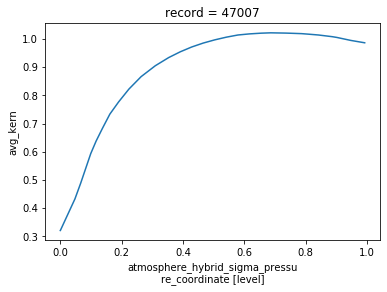

In [42]:
new_avg_kernel[47007,:].plot()

In [45]:
#new_avg_kernel.to_netcdf(output_file)
new_avg_kernel.to_dataset(name='avg_kern')
new_avg_kernel.attrs['comment'] = 'interpolated averaging kernel from OCO2'
new_avg_kernel.to_netcdf(output_file)

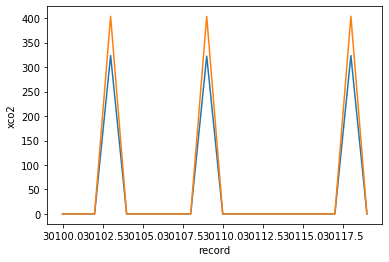

In [52]:
# difference between flattened model output and OCO2 data
co2_profile = ds_model['SpeciesConc_CO2']
tmp = co2_profile * new_avg_kernel
#ds_model['SpeciesConc_CO2'][47007,:].plot()
#tmp[47007,:].plot()
xco2_model = tmp.mean(dim = 'levels')*1e-3 # average along vertical axis, unit: ppbv -> ppm
xco2_model[30100:30120].plot()
ds_satellite['xco2'][30100:30120].plot()

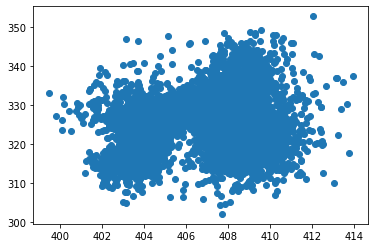

In [53]:
obs = ds_satellite['xco2']
mod = xco2_model
obs[obs == 0] = 'nan'
mod[mod == 0] = 'nan'
plt.scatter(x=obs, y=mod)

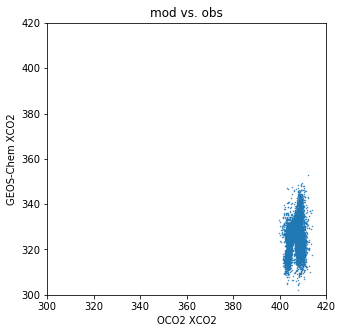

In [54]:
# huge underestimation of XCO2, did I do something wrong with averaging kernel?
fig = plt.figure(figsize=[5, 5])
ax = plt.axes()
plt.scatter(x=obs, y=mod, s=0.2)
plt.xlabel('OCO2 XCO2')
plt.ylabel('GEOS-Chem XCO2')
ax.set_xlim([300,420])
ax.set_ylim([300,420])
ax.set_title('mod vs. obs');

plt.savefig(output_directory+'mod_vs_obs.png', dpi = 300)